In [1]:
#! usr/bin/env python3

import cv2
import pytesseract
from matplotlib import pyplot as plt

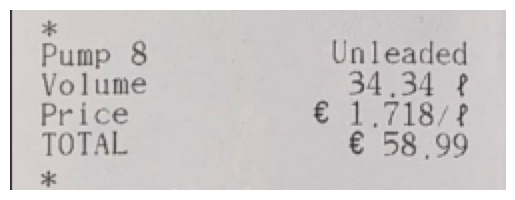

In [2]:
# image_path = 'images/reciepts/rec5.jpg'
# image_path = 'images/reciepts/rec5_v2.jpg'
# image_path = 'images/reciepts/rec5_v3.jpg'
# image_path = 'images/reciepts/rec5_v4.jpg'
image_path = 'images/reciepts/rec5_v5_cut.png'
image = cv2.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [3]:
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return thresh

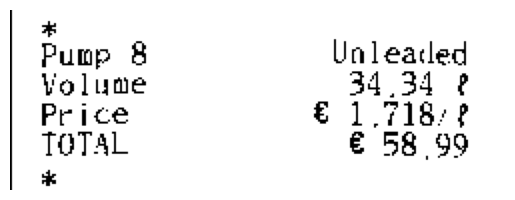

In [4]:
plt.imshow(preprocess(image), cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def ocr_cleanup(image):
    custom_config = r'--oem 3 --psm 6 outputbase'

    text = pytesseract.image_to_string(image, config=custom_config)
    filtered_text = '\n'.join(
        line for line in text.split('\n') if line.strip() != '')
    
    return filtered_text

print(ocr_cleanup(image))

*
Pump 8 Unleaded
Volume 34.34 ¢
Price € 1.718/¢
TOTAL € 58,99
Ps


In [6]:
import re
from fuzzywuzzy import process

# Helper function to extract fuel type
def extract_fuel_type(text_lower, fuel_type_choices):
    fuel_type_match = process.extractOne(text_lower, fuel_type_choices, score_cutoff=50)
    if fuel_type_match:
        return fuel_type_match[0]
    return None

# Helper function to extract volume
def extract_volume(text_lower, volume_pattern):
    volume_match = re.search(volume_pattern, text_lower)
    if volume_match:
        volume = next((m for m in volume_match.groups() if m), None)
        if volume is not None:
            return volume.replace(' ', '').replace(',', '.')
    return None

# Helper function to extract price per litre
def extract_price_per_litre(text_lower, price_per_litre_pattern):
    price_per_litre_match = re.search(price_per_litre_pattern, text_lower)
    if price_per_litre_match:
        price_per_litre = next((m for m in price_per_litre_match.groups() if m), None)
        if price_per_litre is not None:
            return price_per_litre.replace(' ', '').replace(',', '.')
    return None

# Helper function to calculate total
def calculate_total(volume, price_per_litre):
    if volume is not None and price_per_litre is not None:
        total = float(volume) * float(price_per_litre)
        return round(total, 2)
    return None

def no_match_preprocessing(image):
    preprocessed_image = preprocess(image)
    preprocessed_text = ocr_cleanup(preprocessed_image)
    return preprocessed_text

# Main function to extract receipt info
def extract_receipt_info_single(receipt_text, image):
    text_lower = receipt_text.lower()

    info = {
        'fuel_type': None,
        'volume': None,
        'price_per_litre': None,
        'total': None
    }

    volume_pattern = r"(?i)(?:volume|;|:|diesel|unleaded|pump\s*([a-z]|[0-9])|\))\s*(\d+(?:[.,]\d{1,2}))\s*(ltr|l|net)?"
    price_per_litre_pattern = r"(?:price|€)\s*([1-9]?\s*[.,]\d{3})\s*(eur/l|/l|/)?\s*"
    fuel_type_choices = ["unleaded", "diesel"]

    # Extract information using helper functions
    info['fuel_type'] = extract_fuel_type(text_lower, fuel_type_choices)
    
    info['volume'] = extract_volume(text_lower, volume_pattern)
    if info['volume'] is None:
        # Apply preprocessing if volume not found
        preprocessed_text = no_match_preprocessing(image)
        info['volume'] = extract_volume(preprocessed_text.lower(), volume_pattern)
        
    info['price_per_litre'] = extract_price_per_litre(text_lower, price_per_litre_pattern)
    if info['price_per_litre'] is None:
        preprocessed_text = no_match_preprocessing(image)
        info['price_per_litre'] = extract_price_per_litre(preprocessed_text.lower(), price_per_litre_pattern)


    info['total'] = calculate_total(info['volume'], info['price_per_litre'])

    return info

# Example usage
extracted_info_single = extract_receipt_info_single(ocr_cleanup(image), image)
print(extracted_info_single)


{'fuel_type': 'unleaded', 'volume': '34.34', 'price_per_litre': '1.718', 'total': 59.0}


/home/ndavido/.local/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
